In [1]:
import sys
sys.path.append("..")
import logging
import os
from collections import OrderedDict, defaultdict

import hydra
from hydra import initialize, compose
import torch
import wandb
from fvcore.common.checkpoint import Checkpointer, PeriodicCheckpointer
from torch.cuda import amp
from torch.nn import SyncBatchNorm
from torch.nn.parallel import DistributedDataParallel
from tqdm import tqdm
import time

import detectron2.utils.comm as d2_comm
from detectron2.data.catalog import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import DatasetEvaluators, inference_on_dataset
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import CommonMetricPrinter, get_event_storage

from tridet.modeling.dd3d import dense_depth
import tridet.modeling  # pylint: disable=unused-import
import tridet.utils.comm as comm
from tridet.data import build_test_dataloader, build_train_dataloader
from tridet.data.dataset_mappers import get_dataset_mapper
from tridet.data.datasets import random_sample_dataset_dicts, register_datasets
from tridet.evaluators import get_evaluator
from tridet.modeling import build_tta_model
from tridet.utils.s3 import sync_output_dir_s3
from tridet.utils.setup import setup
from tridet.utils.train import get_inference_output_dir, print_test_results
from tridet.utils.visualization import mosaic, save_vis
from tridet.utils.wandb import flatten_dict, log_nested_dict
from tridet.visualizers import get_dataloader_visualizer, get_predictions_visualizer

# from tridet.data.datasets.kitti_3d import register_kitti_3d_datasets
from tridet.data.datasets.custom import register_kitti_3d_datasets
from tridet.data.datasets.nuscenes import register_nuscenes_datasets

from pymongo import MongoClient
from torch.utils.data import Dataset, DataLoader
from kluster import Kluster
from panoramator import Projection, Panoramator, mongo_to_shards
from detectron2.data.common import AspectRatioGroupedDataset, DatasetFromList, MapDataset
from tridet.data.augmentations import build_augmentation
from tridet.utils.tasks import TaskManager
import numpy as np
from tridet.structures.pose import Pose
from typing import List, Union
from detectron2.config import configurable
from detectron2.data import transforms as T
from tridet.evaluators.kitti_3d_evaluator import convert_3d_box_to_kitti
from tridet.utils.geometry import project_points3d
from collections import defaultdict
from copy import deepcopy
import matplotlib.pyplot as plt

#%matplotlib notebook

In [2]:
# Panoramator structures

class PanoramaDataset(Dataset):

    def __init__(self, mongo_args, segments, keyword, projections):
        kluster = Kluster(session=MongoClient(*mongo_args))
        segments = kluster.fetch_data(
            "segments",
            {"_id": {"$in": segments}, "street_view": {"$elemMatch": {"available": True, keyword: {"$exists": False}}}}
        )
        self.kluster = mongo_args
        lines = [
            (segment["_id"], i, line["panoramas"])
            for segment in segments for i, line in enumerate(segment["street_view"])
            if "available" in line and keyword not in line
        ]
        self.panoramas = [(sid, lidx, pidx, panorama)
                          for sid, lidx, panoramas in lines for pidx, panorama in enumerate(panoramas)]
        self.projections = projections

    def __len__(self):
        return len(self.panoramas)

    def __getitem__(self, idx):
        if type(self.kluster) == tuple:
            self.kluster = Kluster(session=MongoClient(*self.kluster))
        segment_id, line_idx, panorama_idx, panorama_id = self.panoramas[idx]
        panorama = main_kluster.kluster["street_view"].find_one({"_id": panorama_id})
        shards = mongo_to_shards(panorama["panorama"])
        panoramator = Panoramator(shards=shards, atomic_resolution=panorama["resolution"][0]//16)
        panoramator.build_state()
        projections = [(projection_meta, panoramator.get_projection(projection_meta))
                       for projection_meta in self.projections]
        return segment_id, line_idx, panorama_id, projections

    
def inference(kluster, predictor, data_loader, keyword):
    current_line = None
    line_count = 0

    for i, (segment_id, line_idx, panorama_id, projections) in enumerate(data_loader):
        itime = time.time()

        if current_line is not None and current_line != (segment_id, line_idx):
            sid, lidx = current_line
            # kluster.kluster["segments"].update_one({"_id": sid}, {"$set": {f"street_view.{lidx}.{keyword}": True}})
            line_count += 1
            print(f"Finished line {line_count}! (Segment:{sid};Index:{lidx})")
        current_line = (segment_id, line_idx)

        result = []
        for projection_meta, projection in projections:
            predictions = predictor(projection)
            result.append({"projection": projection_meta.get_dict(), **predictions})
        # kluster.kluster["street_view"].update_one({"_id": panorama_id}, {"$set": {keyword: result}})

        print(f"Predicted panorama {i+1}/{len(data_loader)} (Time elapsed: {time.time()-itime:.2f}s) ({panorama_id})")

In [3]:
# DD3D structures

class ParkinkDatasetMapper:
    
    @configurable
    def __init__(self, is_train: bool, task_manager, augmentations: List[Union[T.Augmentation, T.Transform]], 
                 image_format: str, intrinsics: list, extrinsics: dict):
        self.is_train = is_train
        self.task_manager = task_manager
        self.augmentations = T.AugmentationList(augmentations)
        print("Augmentations used: " + str(augmentations))
        self.image_format = image_format
        self.intrinsics = intrinsics
        self.extrinsics = extrinsics

    @classmethod
    def from_config(cls, cfg, is_train, intrinsics, extrinsics):
        augs = build_augmentation(cfg, is_train)
        tm = TaskManager(cfg)
        return {"is_train": is_train, "task_manager": tm, "augmentations": augs, "image_format": cfg.INPUT.FORMAT, 
               "intrinsics": intrinsics, "extrinsics": extrinsics}

    def __call__(self, parkink_data):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.
        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        segment_id, line_idx, panorama_id, projections = parkink_data
        
        kitti_projections = []
        for projection_meta, image in projections:
            kitti = {"width": image.shape[1], "height": image.shape[0],
                     "intrinsics": self.intrinsics, "extrinsics": self.extrinsics}
            
            if type(image) == torch.Tensor:  # When using a DataLoader, Tensors instead of arrays will be given
                image = image.numpy()
            image = image[:, :, ::-1]  # VERY IMPORTANT! CONVERT IMAGE FROM RGB (PIL format) TO BGR (model format)
            aug_input = T.AugInput(image)
            transforms = self.augmentations(aug_input)
            image = aug_input.image
            kitti["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))
            
            intrinsics = np.reshape(kitti["intrinsics"], (3, 3)).astype(np.float32)
            intrinsics = transforms.apply_intrinsics(intrinsics)
            kitti["intrinsics"] = torch.as_tensor(intrinsics)
            kitti["inv_intrinsics"] = torch.as_tensor(np.linalg.inv(intrinsics))
            
            extrinsics = Pose(wxyz=np.float32(kitti["extrinsics"]["wxyz"]),
                              tvec=np.float32(kitti["extrinsics"]["tvec"]))
            kitti["extrinsics"] = extrinsics
            
            kitti_projections.append((projection_meta, kitti))
            
        return segment_id, line_idx, panorama_id, kitti_projections


def meter_to_angle(x, y, z):
    # Convert meters coordinates to horizontal and vertical angles.
    # We negate the vertical and so that up is positive and down is negative.
    return np.array([np.arctan2(x, z), -np.arctan2(y, z)]) / np.pi * 180

def process_scene(model, input_dict, plot=False, log=False):
    CLASS_MAPPER = ("Car", "Pedestrian", "Cyclist", "Van", "Truck")
    THRESHOLD = 0.5
    with torch.no_grad():
        raw_output = model([input_dict])[0] #raw_output = model([input_dict])
    #print(raw_output)
    plt.rcParams['figure.figsize'] = [15, 15]
    
    instances = raw_output["instances"].get_fields()
    
    # We discard 
    # - instances["scores"]: scores_3d gives a more informed score, taking into account the 3d box
    # - instances["locations"]: this is ~= object center, but the center given by 3d box is more accurate
    # - instances["pred_boxes"]: 2d boxes, a priori useless if we have 3d ones (is this an intermediate step?)
    # - instances["fpn_levels"]: This is related to at which level of the net the object is detected... useless
    zipped = zip(instances["scores_3d"], instances["pred_classes"], instances["pred_boxes3d"])
    subd = {"pixels": [], "meters": [], "degrees": []}
    prediction = {"score": [], "kitti_class": [], "size": [], "orientation": [], "center": deepcopy(subd),
                  "front_upper_left": deepcopy(subd), "front_upper_right": deepcopy(subd),
                  "front_lower_right": deepcopy(subd), "front_lower_left": deepcopy(subd),
                  "back_upper_left": deepcopy(subd), "back_upper_right": deepcopy(subd),
                  "back_lower_right": deepcopy(subd), "back_lower_left": deepcopy(subd)}
    for score_3d, kitti_class, box_3d in zipped:
        if score_3d < THRESHOLD:  # If the model is not confident enough, we skip the prediction
            continue
        prediction["score"].append(round(score_3d.item(), 3))
        if kitti_class not in (0, 3, 4):  # If the detected object is not a car, van or truck, we skip it
            continue
        kitti_class = CLASS_MAPPER[kitti_class]
        prediction["kitti_class"].append(kitti_class)
        
        center_pix = box_3d.proj_ctr[0].cpu().numpy()  # width (x), height (y)
        center_met = box_3d.tvec[0].cpu().numpy()  # horizontal (left->right), vertical (up->down), depth (back->front)
        center_ang = meter_to_angle(*center_met)  # horizontal (left->right, degrees), vertical (down->up, degrees)
        prediction["center"]["pixels"].append([round(e, 1) for e in center_pix.tolist()])
        prediction["center"]["meters"].append([round(e, 2) for e in center_met.tolist()])
        prediction["center"]["degrees"].append([round(e, 2) for e in center_ang.tolist()])
        
        size = box_3d.size[0].cpu().numpy()  # width, length, height (meters)
        prediction["size"].append([round(e, 2) for e in size.tolist()])
        
        floor_met = center_met + np.array([0, size[2]/2, 0])
        floor_ang = meter_to_angle(*floor_met)
        floor_pix = project_points3d(np.array([floor_met]), input_dict["intrinsics"].numpy())
        print("floor", floor_pix)
        print("center", center_pix)
        
        corners_met = box_3d.corners[0].cpu().numpy()
        corners_ang = np.array([meter_to_angle(*corner) for corner in corners_met])
        corners_pix = project_points3d(corners_met, input_dict["intrinsics"].numpy())
        corners_pix = [pix * (-1 if met[2] < 0 else 1) for met, pix in zip(corners_met, corners_pix)]
        keys = ["front_upper_left", "front_upper_right", "front_lower_right", "front_lower_left", 
                "back_upper_left", "back_upper_right", "back_lower_right", "back_lower_left"]
        for key, pix, met, ang in zip(keys, corners_pix, corners_met, corners_ang):
            prediction[key]["pixels"].append([round(e, 1) for e in pix.tolist()])
            prediction[key]["meters"].append([round(e, 2) for e in met.tolist()])
            prediction[key]["degrees"].append([round(e, 2) for e in ang.tolist()])
        
        w, l, h, x, y, z, roty, alpha = convert_3d_box_to_kitti(box_3d)
        orientation = - alpha / np.pi * 180  # The alpha in angles.png, clockwise is positive (180 to -180 range) (90 means we see car back) (-90 means we see car front)        prediction["orientation"].append(round(orientation, 2))
        print("orientation", orientation)
        
        if log:
            print(f"Confidence: {score_3d}")
            print(f"Class: {kitti_class}")
            print(f"Center (pixels): {center_pix}")
            print(f"Center (meters): {center_met}")
            print(f"Center (degrees): {center_ang}")
            print(f"Size (meters): {size}")
            print(f"Corners (pixels): {corners_pix}")
            print(f"Corners (meters): {corners_met}")
            print(f"Corners (degrees): {corners_ang}")
            print(f"Car Orientation (degrees): {orientation}")
        
        if plot:
            for a, b, c, d in [(0, 1, 2, 3), (4, 5, 6, 7), (0, 4, 7, 3), (1, 5, 6, 2), (0, 2, 1, 3)]:
                coord = [corners_pix[a], corners_pix[b], corners_pix[c], corners_pix[d], corners_pix[a]] 
                xs, ys = zip(*coord)
                plt.plot(xs, ys, color='r')
    
    if plot:
        img = input_dict["image"].cpu().numpy().transpose(1, 2, 0)[:, :, ::-1]
        plt.imshow(img)
        plt.show()
    
    return prediction

    """
    LEVELS = 1
    
    if plot:
        plt.rcParams['figure.figsize'] = [9, 4.5*(LEVELS+1)]#[9, 4.5]
        fig, axes = plt.subplots(LEVELS+1, 1)
        img = input_dict["image"].cpu().numpy().transpose(1, 2, 0)[:, :, ::-1]
        axes[0].imshow(img)
        #plt.imshow(img)
        #plt.show()

        for i, element in enumerate(raw_output[:LEVELS]):
            axes[i+1].imshow(element.squeeze().cpu().numpy(), cmap=cm.get_cmap("plasma")) # "plasma_r"
            #plt.imshow(element.squeeze().cpu().numpy(), cmap="plasma")
            #plt.show()
            #print(element.shape)
        #print(raw_output)
    
    #from pprint import pprint
    #pprint(prediction)
    """
    return {}

In [4]:
CFG_PATH = "../configs/"
CFG_NAME = "kitti99_defaults"
CHECKPOINT = "../models/kitti_v99.pth"#"../models/depth_pretrained_v99.pth" #
#INTRINSICSDD3D = [612.6, 0.0, 640.0, 0.0, 612.6, 128.0, 0.0, 0.0, 1.0]
INTRINSICS = [707, 0.0, 640.0, 0.0, 707, 128.0, 0.0, 0.0, 1.0]
INTRINSICS = [728.5, 0.0, 640.0, 0.0, 728.5, 192.0, 0.0, 0.0, 1.0]
INTRINSICS = [622.2, 0.0, 640.0, 0.0, 622.2, 192.0, 0.0, 0.0, 1.0]
INTRINSICS = [728.5, 0.0, 640.0, 0.0, 546.7, 192.0, 0.0, 0.0, 1.0]
#INTRINSICS = [728.5*2, 0.0, 640.0*2, 0.0, 728.5*2, 256.0*2, 0.0, 0.0, 1.0]
EXTRINSICS = {"wxyz": [1.0, 0.0, 0.0, 0.0], "tvec": [0.0, 0.0, 0.0]}

In [5]:
MONGO_SESSION_ARGS = ("localhost", 27017)
PREDICTION_KEYWORD = "kitti_cars"
TIMEOUT = 180
"""
PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=92.5, fov_vertical=45.36,
                          full_resolution_x=1280, full_resolution_y=512,
                          offset_x=0, offset_y=512-384, resolution_x=1280, resolution_y=384),
               Projection(center_horizontal=180, center_vertical=0, fov_horizontal=92.5, fov_vertical=45.36,
                          full_resolution_x=1280, full_resolution_y=512,
                          offset_x=0, offset_y=512-384, resolution_x=1280, resolution_y=384)]
PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=60, fov_vertical=49.58,
                          full_resolution_x=640, full_resolution_y=512,
                          offset_x=0, offset_y=512-384, resolution_x=640, resolution_y=384)]
"""
PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=82.6, fov_vertical=38.7,
                          full_resolution_x=1280, full_resolution_y=512,
                          offset_x=0, offset_y=512-384, resolution_x=1280, resolution_y=384),
               Projection(center_horizontal=180, center_vertical=0, fov_horizontal=82.6, fov_vertical=38.7,
                          full_resolution_x=1280, full_resolution_y=512,
                          offset_x=0, offset_y=512-384, resolution_x=1280, resolution_y=384)]
PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=82.6, fov_vertical=47.5,
                          full_resolution_x=1280, full_resolution_y=640,
                          offset_x=0, offset_y=640-384, resolution_x=1280, resolution_y=384),
               Projection(center_horizontal=180, center_vertical=0, fov_horizontal=82.6, fov_vertical=47.5,
                          full_resolution_x=1280, full_resolution_y=640,
                          offset_x=0, offset_y=640-384, resolution_x=1280, resolution_y=384)]
"""
PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=82.6, fov_vertical=29.6,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384),
               Projection(center_horizontal=180, center_vertical=0, fov_horizontal=82.6, fov_vertical=29.6,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384)]

PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=82.6, fov_vertical=47.4,
                          full_resolution_x=1280, full_resolution_y=640,
                          offset_x=0, offset_y=640-384, resolution_x=1280, resolution_y=384),
               Projection(center_horizontal=180, center_vertical=0, fov_horizontal=82.6, fov_vertical=47.4,
                          full_resolution_x=1280, full_resolution_y=640,
                          offset_x=0, offset_y=640-384, resolution_x=1280, resolution_y=384)]


PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=82.6, fov_vertical=38.7,
                          full_resolution_x=1280, full_resol        print("center", center_met)
        print("size", size)ution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384)]
PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=82.6, fov_vertical=38.7,
                          full_resolution_x=1280, full_resolution_y=512,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=512),
              Projection(center_horizontal=180, center_vertical=0, fov_horizontal=82.6, fov_vertical=38.7,
                          full_resolution_x=1280, full_resolution_y=512,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=512)]
"""

PROJECTIONS = [Projection(center_horizontal=0, center_vertical=-1, fov_horizontal=82.6, fov_vertical=38.7,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384),
              Projection(center_horizontal=180, center_vertical=-1, fov_horizontal=82.6, fov_vertical=38.7,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384)]  # 546.7

"""
PROJECTIONS = [Projection(center_horizontal=0, center_vertical=0, fov_horizontal=82.6, fov_vertical=34.2,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384),
              Projection(center_horizontal=180, center_vertical=0, fov_horizontal=82.6, fov_vertical=34.2,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384)]

PROJECTIONS = [Projection(center_horizontal=0, center_vertical=-2, fov_horizontal=82.6, fov_vertical=29.6,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384),
               Projection(center_horizontal=180, center_vertical=-2, fov_horizontal=82.6, fov_vertical=29.6,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384)]

PROJECTIONS = [Projection(center_horizontal=0, center_vertical=-1, fov_horizontal=82.6, fov_vertical=36.7,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384),
               Projection(center_horizontal=180, center_vertical=-1, fov_horizontal=82.6, fov_vertical=36.7,
                          full_resolution_x=1280, full_resolution_y=384,
                          offset_x=0, offset_y=0, resolution_x=1280, resolution_y=384)] # 578.9
"""
MIN_LAT, MAX_LAT = 41.35, 41.5
MIN_LON, MAX_LON = 2.1, 2.3
PLOT = True
LOG = False

In [6]:
# StreetView initializations
main_kluster = Kluster(session=MongoClient(*MONGO_SESSION_ARGS))
bounding_polygon = [(MIN_LAT, MIN_LON), (MIN_LAT, MAX_LON), (MAX_LAT, MAX_LON),
                    (MAX_LAT, MIN_LON), (MIN_LAT, MIN_LON)]
bounding_polygon = {"type": "Polygon", "coordinates": [[[lon, lat] for lat, lon in bounding_polygon]]}

In [7]:
# DD3D initializations
with initialize(config_path=CFG_PATH):
    cfg = compose(config_name=CFG_NAME)
setup(cfg)
dd3d_model = build_model(cfg).eval()
Checkpointer(dd3d_model).load(CHECKPOINT)
dd3d_predictor = lambda image: process_scene(dd3d_model, image, plot=PLOT, log=LOG)

In [8]:
# Load segment_ids of interest
ways = main_kluster.fetch_data("ways", {"path": {"$geoIntersects": {"$geometry": bounding_polygon}}})
segment_ids = [seg_id for way in ways for seg_id in way["segments"].values()]

In [9]:
# Dataset and Loader
dataset = PanoramaDataset(MONGO_SESSION_ARGS, segment_ids, PREDICTION_KEYWORD, PROJECTIONS)
mapper = ParkinkDatasetMapper(cfg, is_train=False, intrinsics=INTRINSICS, extrinsics=EXTRINSICS)
dataset = MapDataset(dataset, mapper)
loader = DataLoader(dataset, batch_size=None, num_workers=0)

Augmentations used: [ResizeShortestEdge(short_edge_length=(384, 384), max_size=100000, sample_style='choice')]


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.8/dist-packages/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


floor [[187.02531849 260.6784615 ]]
center [187.02008 236.7132 ]
orientation -111.1538122553797
floor [[143.91120507 245.64578346]]
center [143.86827 225.11104]
orientation -107.14310768946395
floor [[262.25636509 223.51519963]]
center [262.2257 210.9856]
orientation -93.965078401455


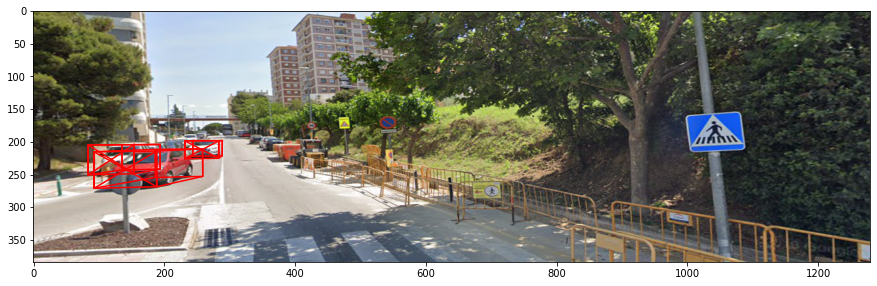

floor [[287.00011332 257.65682018]]
center [286.8842 232.3699]
orientation -16.615776058793873
floor [[ 64.30629991 244.00144609]]
center [ 64.24942 220.15363]
orientation -52.13915935690492
floor [[918.34080708 295.23905867]]
center [918.52966 258.9467 ]
orientation -149.54198452914486


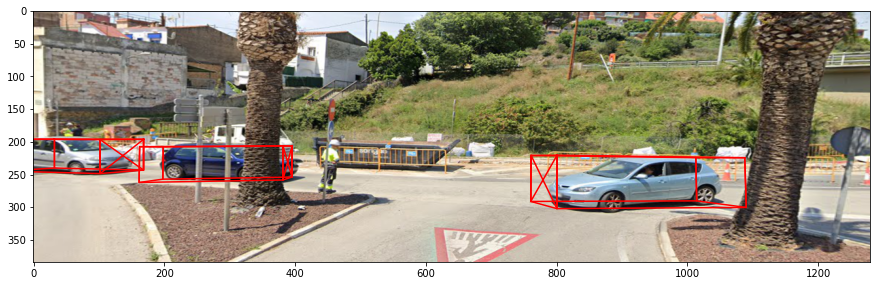

Predicted panorama 1/1096 (Time elapsed: 0.50s) (6012badb5f0e64702deb315f)
Finished line 1! (Segment:0bffcbb513889f47e2034028;Index:0)
floor [[461.70603192 246.24835597]]
center [461.82834 221.77356]
orientation -103.705360918679
floor [[245.26064113 328.36985118]]
center [245.26251 284.96515]
orientation -120.32113697747289
floor [[762.38016867 267.38067181]]
center [762.4618  242.83463]
orientation 101.98648753328652
floor [[644.90981039 252.24874421]]
center [644.89557 229.69771]
orientation 89.95437383553926
floor [[494.94764516 234.68773299]]
center [494.91733 219.79723]
orientation -100.8405719430249
floor [[729.88836527 249.09973126]]
center [729.88837 229.99168]
orientation 95.11099399171665
floor [[595.92217043 212.30613897]]
center [595.82874 203.64359]
orientation -97.97578296737076


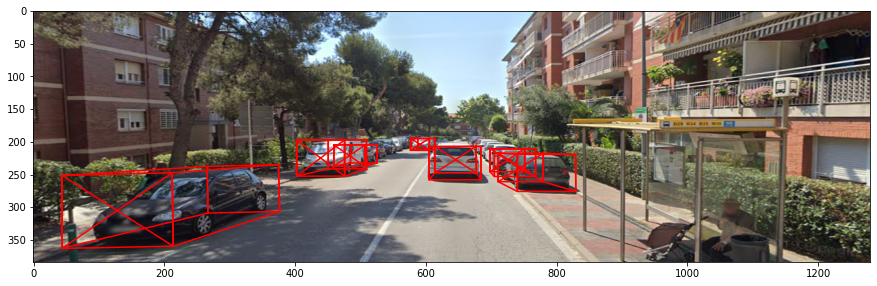

floor [[779.37587768 259.34262063]]
center [779.32635 242.27107]
orientation 119.17522138721122
floor [[592.42305266 264.48738544]]
center [592.31915 243.48917]
orientation -74.48451336700703
floor [[-10.8153445  338.96896323]]
center [-10.8895645 284.85056  ]
orientation 138.65578642165923
floor [[727.38900199 249.31713102]]
center [727.65393 234.76797]
orientation 122.04001036286533
floor [[542.93553687 337.89136532]]
center [543.1533  290.85718]
orientation -116.88339020668793
floor [[846.3589735  272.98879391]]
center [846.45996 253.00104]
orientation 121.46705256773454
floor [[525.93983084 242.09183072]]
center [526.2402  229.69757]
orientation -61.30648407899809
floor [[668.9037569  242.28473437]]
center [669.0958  230.45795]
orientation 127.19663051904277


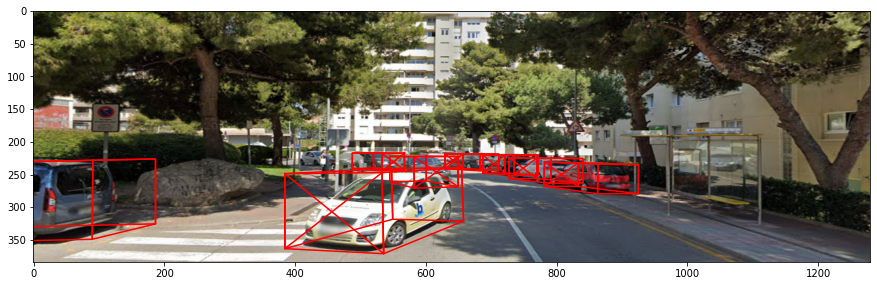

Predicted panorama 2/1096 (Time elapsed: 0.49s) (6012badb5f0e64702deb862a)
floor [[819.86566133 315.45561789]]
center [819.7964 276.6002]
orientation 102.55944532841737
floor [[451.95848707 251.59522066]]
center [451.93506 233.7405 ]
orientation -105.99719209920231
floor [[731.8878683  248.84186195]]
center [731.8301 229.4267]
orientation 97.40282517223994
floor [[280.75171003 315.27173837]]
center [280.7328  263.99255]
orientation -115.7374746164263
floor [[760.38067884 268.53199169]]
center [760.55457 244.25134]
orientation 100.8405719430249
floor [[488.44929367 238.17748075]]
center [488.49176 222.55443]
orientation -102.55944532841737
floor [[530.93856802 252.82609194]]
center [530.8336  232.29634]
orientation -99.12169855763241
floor [[642.41044121 234.15997158]]
center [642.3884  217.55858]
orientation 91.1002894258009
floor [[394.22305944 274.44231762]]
center [394.28793 249.88889]
orientation -110.00789666511805
floor [[711.89291171 237.72711568]]
center [712.2262 221.6478]
ori

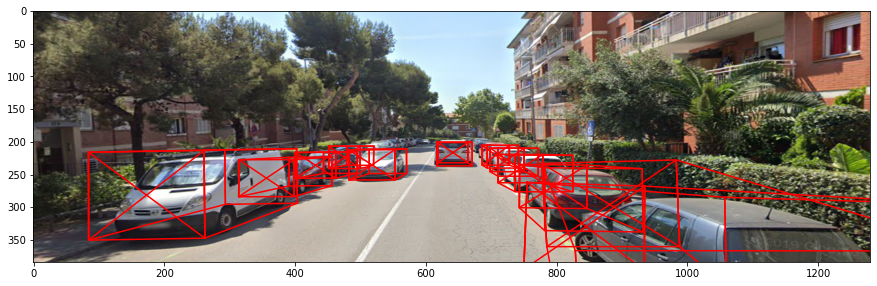

floor [[324.49065542 245.74712049]]
center [324.4185  222.67104]
orientation 166.15776058793872
floor [[763.37991387 239.18367432]]
center [763.4212  227.24078]
orientation 118.60226359208039
floor [[621.41573875 249.08976265]]
center [621.738   231.69115]
orientation -98.54874076250161


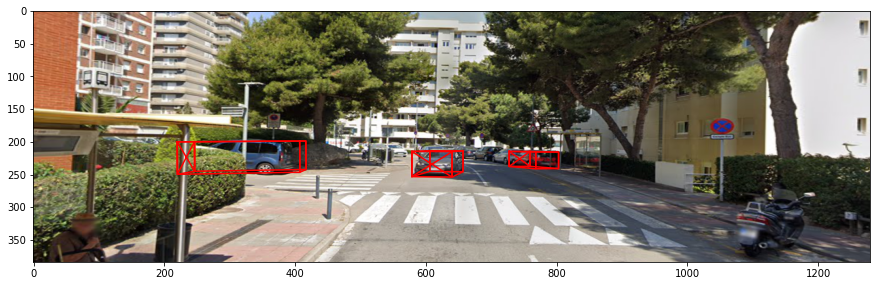

Predicted panorama 3/1096 (Time elapsed: 0.49s) (6012badb5f0e64702deb8ccd)
floor [[826.36401802 316.45217765]]
center [826.6867 275.7714]
orientation 103.705360918679
floor [[382.2260796  273.89783912]]
center [382.2775  247.37943]
orientation -111.1538122553797
floor [[514.94260615 228.65948948]]
center [514.9465  212.96405]
orientation -100.26761414789408
floor [[451.70855098 251.80073487]]
center [451.6449  233.12642]
orientation -104.85127650894066
floor [[488.19935517 237.29891894]]
center [488.23788 220.60925]
orientation -101.98648753328652
floor [[733.88735708 250.13184239]]
center [734.2395  229.22061]
orientation 97.40282517223994
floor [[638.4114501  227.91861622]]
center [638.3198  212.26413]
orientation 92.24620501606255
floor [[707.89391873 227.15740181]]
center [707.8788  213.79332]
orientation 96.82986737710912
floor [[251.75899969 324.0776924 ]]
center [251.71442 284.45633]
orientation -119.17522138721122
floor [[-179.00729779  507.63743204]]
center [-179.1687   404.56

KeyboardInterrupt: 

In [10]:
inference(main_kluster, dd3d_predictor, loader, PREDICTION_KEYWORD)

Mapper should match keys `instrinsics`, `width`, `height`, `extrinsics` from 
{'intrinsics': [612.6, 0.0, 640.0, 0.0, 612.6, 128.0, 0.0, 0.0, 1.0],
 'file_name': '/workspace/dd3d/datasets/KITTI3D/inference/image_2/a_back.jpg',
 'width': 1280,
 'height': 384,
 'image_id': 'a_back_camera_2',
 'sample_id': 'a_back',
 'extrinsics': {'wxyz': [1.0, 0.0, 0.0, 0.0], 'tvec': [0.0, 0.0, 0.0]}}
for each projection element in the list.

Additionally, it should follow the default mapper logic to obtain the mapped dataset. i.e.
{'intrinsics': tensor([[612.6000,   0.0000, 640.0000],
        [  0.0000, 612.6000, 128.0000],
        [  0.0000,   0.0000,   1.0000]]), 'file_name': '/workspace/dd3d/datasets/KITTI3D/inference/image_2/a_back.jpg', 'width': 1280, 'height': 384, 'image_id': 'a_back_camera_2', 'sample_id': 'a_back', 'extrinsics': wxyz: +1.000 +0.000i +0.000j +0.000k, tvec: ([0.00 0.00 0.00]), 'image': tensor([[[100, 127, 144,  ...,  62,  80,  95],
         [106, 120, 126,  ...,  67,  86,  99],
         [ 72,  82,  91,  ...,  69,  88, 100],
         ...,
         [254, 254, 254,  ...,  54,  67,  67],
         [254, 254, 254,  ...,  37,  53,  60],
         [254, 254, 254,  ...,  14,  32,  42]],

        [[120, 147, 164,  ...,  71,  89, 104],
         [127, 141, 147,  ...,  76,  95, 108],
         [ 94, 104, 113,  ...,  78,  97, 109],
         ...,
         [254, 254, 254,  ...,  75,  86,  86],
         [254, 254, 254,  ...,  58,  71,  78],
         [254, 254, 254,  ...,  35,  50,  60]],

        [[121, 148, 165,  ...,  75,  93, 108],
         [128, 142, 148,  ...,  80,  99, 112],
         [ 92, 102, 111,  ...,  82, 101, 113],
         ...,
         [254, 254, 254,  ...,  72,  83,  83],
         [254, 254, 254,  ...,  56,  70,  77],
         [254, 254, 254,  ...,  33,  49,  59]]], dtype=torch.uint8), 'inv_intrinsics': tensor([[ 0.0016,  0.0000, -1.0447],
        [ 0.0000,  0.0016, -0.2089],
        [ 0.0000,  0.0000,  1.0000]])}